# CLIMATE AND SUSTAINABILITY ANALYSIS
This project analyzes global sustainability indicators by combining multiple datasets on CO₂ emissions, GDP per capita, renewable energy, and population.

The workflow includes:

Cleaning and preprocessing raw datasets

Selecting the most relevant 100–125 countries based on emission size and data reliability

Interpolating missing values to create a complete dataset

Generating derived indicators such as CO₂ intensity of GDP, renewable share, and growth rates

Visualizing global and country-level trends in CO₂, GDP, population, and renewable energy

The goal is to understand the relationship between economic growth, energy transition, and emissions for policy insights and sustainability research.

In [ ]:
#Importing essential libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [58]:
#Load datasets

renewable_df=pd.read_csv('../climate_data/renewable_energy.csv')
population_df=pd.read_csv('../climate_data/population.csv')
co2_df=pd.read_csv('../climate_data/co2_emissions.csv')
gdp_df=pd.read_csv('../climate_data/gdp_percapita.csv')

#Quick preview
gdp_df.head()

,Entity,Code,Year,"GDP per capita, PPP (constant 2021 international $)",World regions according to OWID
0,Afghanistan,AFG,2000,1617.8264,NaN
1,Afghanistan,AFG,2001,1454.1108,NaN
2,Afghanistan,AFG,2002,1774.3087,NaN
3,Afghanistan,AFG,2003,1815.9282,NaN
4,Afghanistan,AFG,2004,1776.9182,NaN


### CLEANING

In [59]:
# Data cleaning
'''
- Remove unnecessary columns
- Standardize column names
- Keep only required features
'''

gdp_df.drop(columns=['World regions according to OWID'], inplace=True)
renewable_df.drop(columns=['Code'], inplace=True)
cols_to_keep=['country', 'year', 'co2', 'co2_per_capita','coal_co2', 'oil_co2', 'gas_co2',]
co2_df=co2_df[cols_to_keep].copy()
drop_rows= ['High-income countries', 'World', 'International shipping', 'Asia (GCP)', 'Asia (excl. China and India)', 'Africa (GCP)', 'Central America (GCP)', 'Europe (GCP)', 'Europe (excl. EU-27)',
       'Europe (excl. EU-28)', 'European Union (27)',
       'European Union (28)', 'International aviation', 'International shipping', 'Kuwaiti Oil Fires (GCP)', 'Low-income countries',
       'Lower-middle-income countries', 'Middle East (GCP)', 'Non-OECD (GCP)', 'North America (GCP)', 'North America (excl. USA)', 'OECD (GCP)', 'Oceania (GCP)', 'South America (GCP)', 'Upper-middle-income countries']
co2_df=co2_df[~co2_df['country'].isin(drop_rows)].copy()

gdp_df=gdp_df.rename(columns={'Entity': 'country', 'Year': 'year', 'GDP per capita, PPP (constant 2021 international $)': 'gdp_per_capita'})
population_df= population_df.rename(columns={'Entity': 'country', 'Year': 'year', 'all years': 'population'})
renewable_df.rename(columns={'Entity': 'country', 'Year': 'year', 'Renewables (% equivalent primary energy)': 'renewable_energy_consumption'}, inplace=True)

In [60]:
# Checking for missing values

print(renewable_df.isna().sum())
print(gdp_df.isna().sum())
print(population_df.isna().sum())

gdp_df=gdp_df.dropna(subset=['gdp_per_capita'])

# Identify top CO2 emitting countries
emissions = co2_df.groupby("country")["co2"].sum().sort_values(ascending=False)
top_emitters = emissions.head(75).index.tolist()

# Select reliable smaller emitters
null_ratio = co2_df.groupby("country")["co2"].apply(lambda x: x.isnull().mean())
reliable_minor = null_ratio[null_ratio < 0.2].index.tolist()

# Final country selection (~125 total)
selected = list(set(top_emitters + reliable_minor))[:125]

# Keep only the selected countries and sort data by country and year
co2_df = co2_df[co2_df["country"].isin(selected)]
co2_df = co2_df.sort_values(["country", "year"])

# Hnadle missing values in numerical columns
numeric_cols=co2_df.select_dtypes(include=["number"]).columns
co2_df[numeric_cols] = co2_df.groupby("country")[numeric_cols].transform(
    lambda x: x.interpolate().ffill().bfill()
)
co2_df[numeric_cols] = co2_df[numeric_cols].fillna(co2_df[numeric_cols].mean())

co2_df.to_csv("co2_dataset_cleaned.csv", index=False)

country                         0
year                            0
renewable_energy_consumption    0
dtype: int64
country             0
Code              473
year                0
gdp_per_capita     81
dtype: int64
country       0
year          0
population    0
dtype: int64


In [62]:
# Merging datasets into one major dataset on year and country

fulldata_df=pd.merge(co2_df, population_df, on=['country', 'year'], how='inner')
fulldata_df=pd.merge(fulldata_df, gdp_df, on=['country', 'year'], how='inner')
fulldata_df=pd.merge(fulldata_df, renewable_df, on=['country', 'year'], how='inner')

In [63]:
# Add derived indicators

fulldata_df["co2_intensity_gdp"] = fulldata_df["co2"] / fulldata_df["gdp_per_capita"]
fulldata_df=fulldata_df.sort_values(['country', 'year'])

In [64]:
# Growth indicators

fulldata_df['co2_growth'] = fulldata_df.groupby('country')['co2'].pct_change() 
fulldata_df['gdp_growth'] = fulldata_df.groupby('country')['gdp_per_capita'].pct_change()
fulldata_df['renewable_growth'] = fulldata_df.groupby('country')['renewable_energy_consumption'].pct_change()
fulldata_df["renewable_share"] = fulldata_df["renewable_energy_consumption"] / (fulldata_df["renewable_energy_consumption"] + fulldata_df['co2'])

### VISUALIZATION

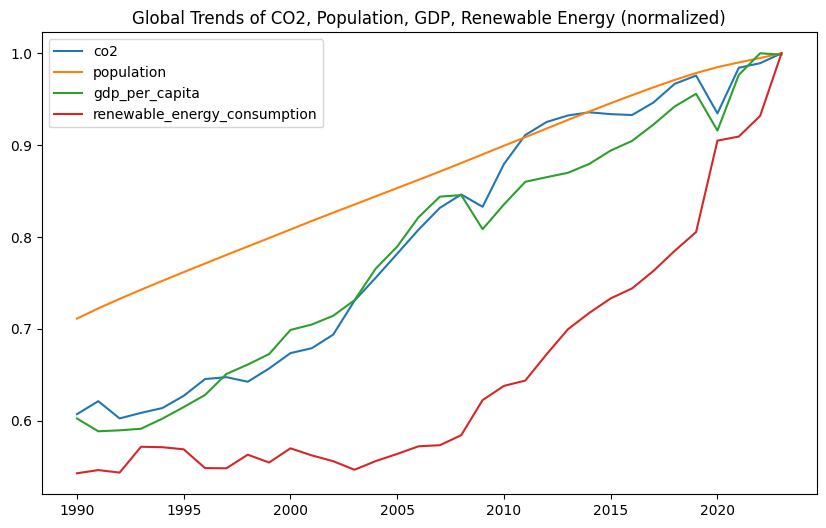

In [65]:
# Visualizing global trends

global_trends = fulldata_df.groupby("year")[["co2", "population", "gdp_per_capita", "renewable_energy_consumption"]].sum()
plt.figure(figsize=(10,6))
normalized=global_trends / global_trends.max()
for col in normalized.columns:
    plt.plot(normalized.index, normalized[col], label=col)
plt.title("Global Trends of CO2, Population, GDP, Renewable Energy (normalized)")
plt.legend()
plt.show()

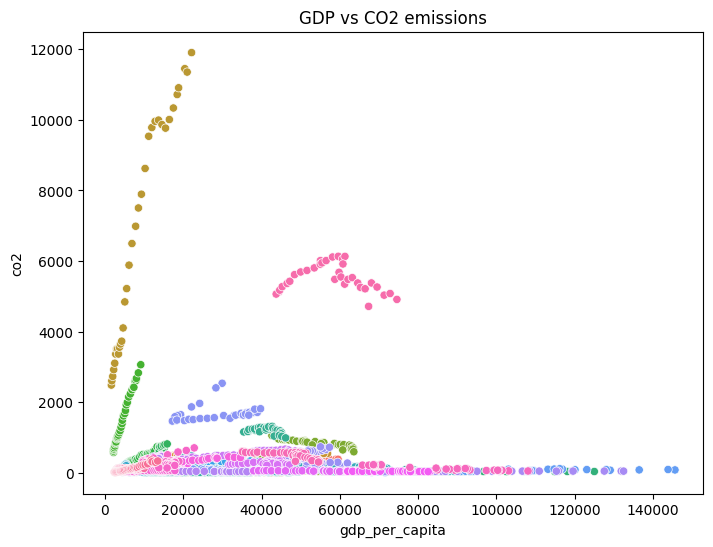

In [66]:
# Visualizing GDP vs CO2 emissions

plt.figure(figsize=(8,6))
sns.scatterplot(data=fulldata_df, x="gdp_per_capita", y="co2", hue="country", legend=False)
plt.title("GDP vs CO2 emissions")
plt.show()

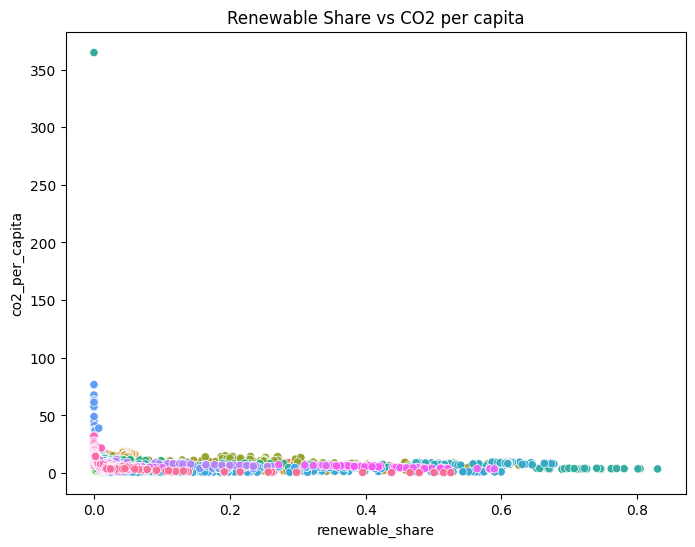

In [67]:
# Visualizing Renewable Share vs CO2 per capita

plt.figure(figsize=(8,6))
sns.scatterplot(data=fulldata_df, x="renewable_share", y="co2_per_capita", hue="country", legend=False)
plt.title("Renewable Share vs CO2 per capita")
plt.show()

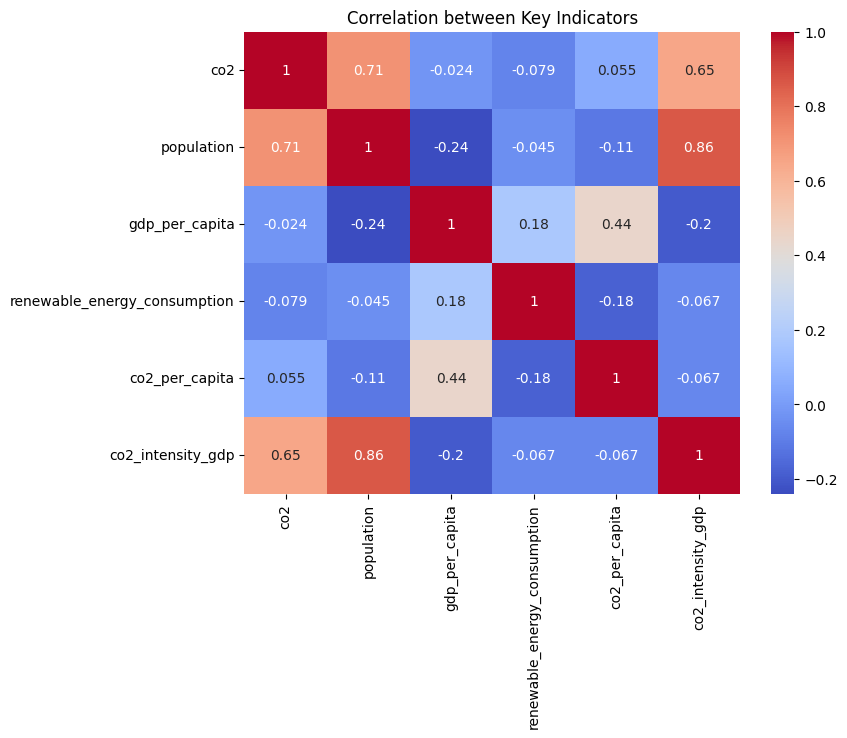

In [68]:
# Correlation heatmap of key indicators

plt.figure(figsize=(8,6))
sns.heatmap(fulldata_df[["co2","population","gdp_per_capita","renewable_energy_consumption",
                       "co2_per_capita","co2_intensity_gdp"]].corr(), annot=True, cmap="coolwarm")
plt.title("Correlation between Key Indicators")
plt.show()

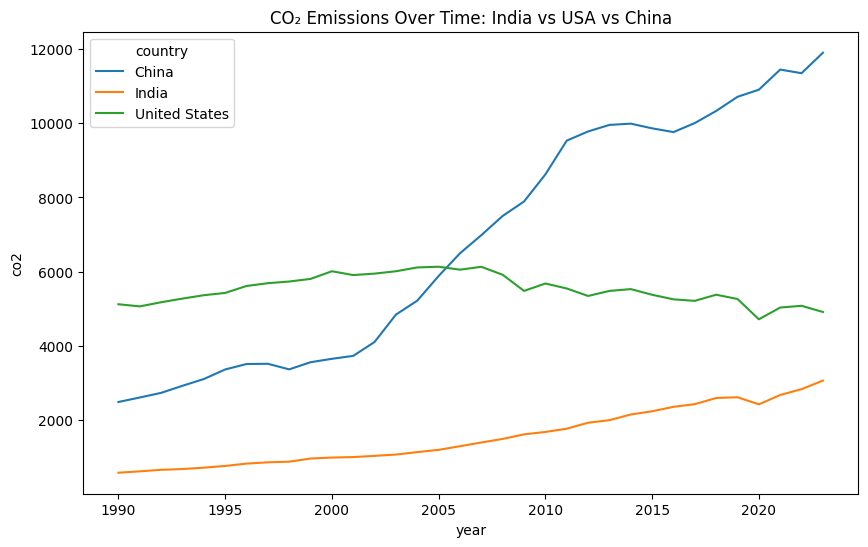

In [69]:
# Visualizing CO₂ emissions over time for specific countries (India, United States, China)

case_countries = ["India", "United States", "China"]
case_df = fulldata_df[fulldata_df["country"].isin(case_countries)]

plt.figure(figsize=(10,6))
sns.lineplot(data=case_df, x="year", y="co2", hue="country")
plt.title("CO₂ Emissions Over Time: India vs USA vs China")
plt.show()

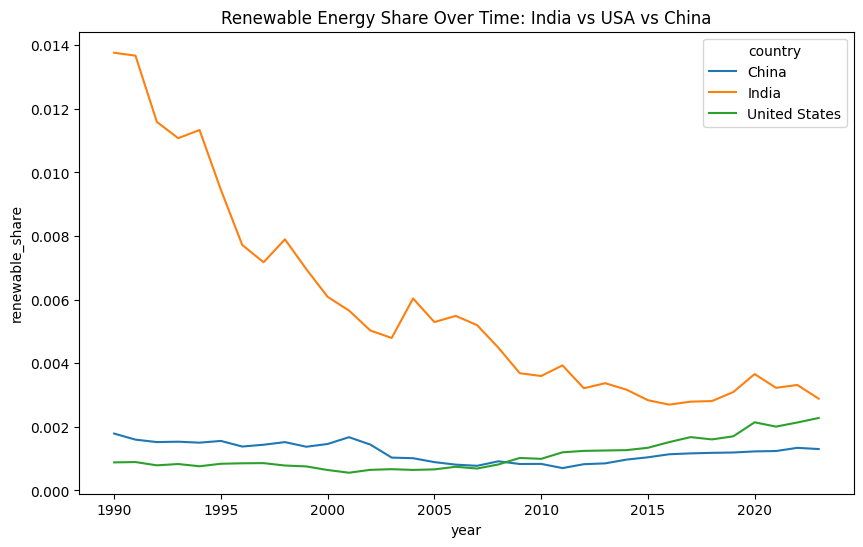

In [70]:
# Visualizing Renewable Share over time for specific countries (India, United States, China)

plt.figure(figsize=(10,6))
sns.lineplot(data=case_df, x="year", y="renewable_share", hue="country")
plt.title("Renewable Energy Share Over Time: India vs USA vs China")
plt.show()

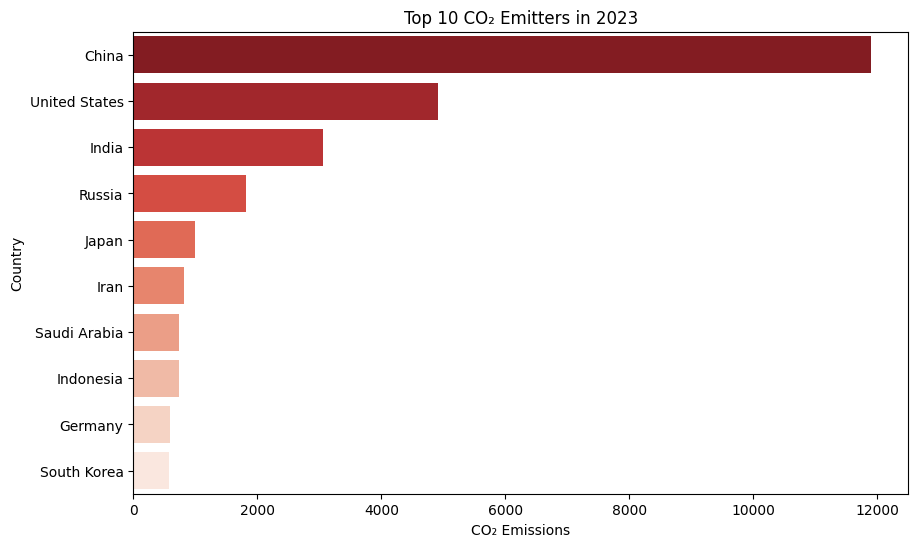

In [71]:
# Visualizing top CO₂ emitters

year = 2023
top_emitters = (fulldata_df[fulldata_df["year"] == year].sort_values("co2", ascending=False).head(10))

plt.figure(figsize=(10,6))
sns.barplot(data=top_emitters, x="co2", y="country", hue="country", palette="Reds_r")
plt.title(f"Top 10 CO₂ Emitters in {year}")
plt.xlabel("CO₂ Emissions")
plt.ylabel("Country")
plt.show()

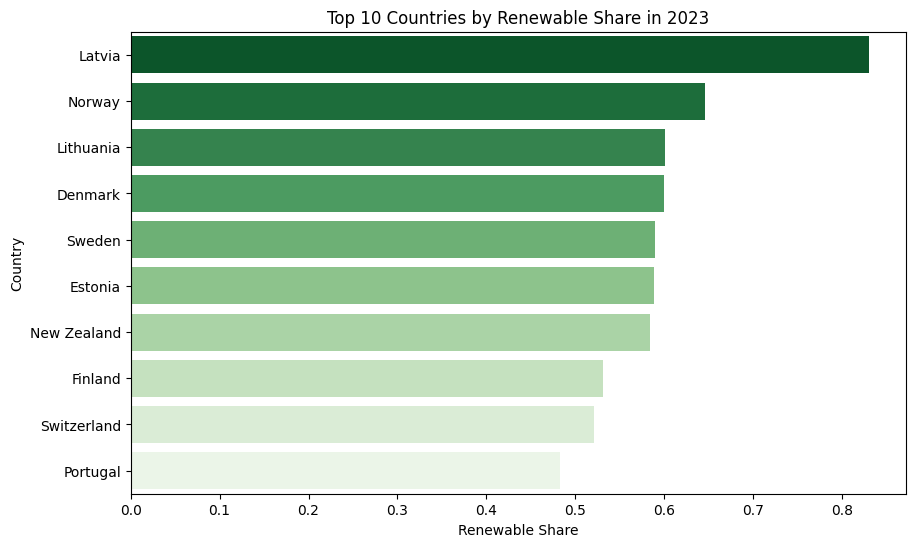

In [72]:
# Visualizing top Renewable Share countries

top_renewables = (fulldata_df[fulldata_df["year"] == year].sort_values("renewable_share", ascending=False).head(10))

plt.figure(figsize=(10,6))
sns.barplot(data=top_renewables, x="renewable_share", y="country", hue='country', palette="Greens_r")
plt.title(f"Top 10 Countries by Renewable Share in {year}")
plt.xlabel("Renewable Share")
plt.ylabel("Country")
plt.show()

In [73]:
# Saving the processed DataFrame to a CSV file

fulldata_df.to_csv("sustainability_master_dataset.csv", index=False)